# 1 практическое задание. Полносвязная нейронная сеть на `numpy`.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__4 марта 02:00__</span>.

Мягкий дедлайн: <span style="color:red">__17 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __3 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

In [2]:
import numpy as np
import pandas as pd

from collections import OrderedDict
from typing import Optional, Union

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, normalize
from sklearn.datasets import load_digits

from termcolor import colored
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## Теоретическая часть (3 балла)

В этом блоке вам нужно решить 3 задания.

### Задание 1. Градиенты для слоя Batch normalization (1.5 балла)

Рассмотрим слой Batch normalization. Пусть на вход этого слоя был подан батч из $n$ объектов, при этом у всех объектов по 1 признаку. Представим вход BN слоя в виде $X \in \mathbb{R}^{n \times 1}$.

Тогда в этом слое производятся следующие вычисления:

$$ \mu = \frac1n \sum_{i=1}^{n} X_i $$

$$ \sigma^2 = \frac1n \sum_{i=1}^{n} \left( X_i - \mu \right) ^2 $$

$$ \tilde{y_i} = \frac{X_i - \mu}{\sqrt{\sigma^2 + \varepsilon}} $$

$$ y_i = \gamma \tilde{y_i} + \delta $$

Выходом BN слоя является $y_i$, а $\gamma$ и $\delta$ в нем — параметры, которые подбираются во время обучения вместе с другими параметрами нейронной сети (наряду, например, с весами линейного слоя).

Рассмотрим нейронную сеть, в которой есть BN слой. Предположим, что вычисления в нейронной завершаются подсчетом функции потерь $\mathcal{L}$. Пусть мы выполнили прямой проход по нейронной сети и сейчас делаем обратный проход с помощью метода обратного распространения ошибки. Пусть BN слою пришел градиент функции потерь по выходу BN слоя ($\nabla_{y} \mathcal{L}$).

В этом задании вам нужно записать вычисление градиента функции потерь по параметрам слоя BN $\gamma$ и $\delta$ ($\nabla_{\gamma} \mathcal{L}$, $\nabla_{\delta} \mathcal{L}$) через $\nabla_{y} \mathcal{L}$, а также вам нужно записать вычисление градиента функции потерь по входу слоя BN $X$ ($\nabla_{X} \mathcal{L}$) через $\nabla_{y} \mathcal{L}$.

Хочу заметить, в данном задании мы рассматриваем объекты всего с 1 признаком, чтобы упростить выкладки.

Ответ:

$\nabla_{X} \mathcal{L} = (\frac{\delta L}{\delta x_1}, ..., \frac{\delta L}{\delta x_n})^T$

Cогласно формулам полной частной производной: 

0. $\frac{\delta L}{\delta x_i} = \{ L = L(\tilde{y_i}(x_i), \sigma(x_i), \mu(x_i))\} = \frac{\delta L}{\delta \tilde{y_i}} \frac{\delta \tilde{y_i}}{\delta x_i}  + \frac{\delta L}{\delta \sigma^2} \frac{\delta \sigma^2}{\delta x_i}
+ \frac{\delta L}{\delta \mu} \frac{\delta \mu}{\delta x_i}$

1. $\frac{\delta L}{\delta \tilde{y_i}} = \{L = L(y_i(\tilde{y_i}))\} = \frac{\delta L}{\delta y_i} 
\frac{\delta y_i}{\delta \tilde{y_i}} = \frac{\delta L}{\delta y_i} \gamma$

2. $\frac{\delta \tilde{y_i}}{\delta x_i} = \frac{1}{\sqrt{\sigma^2 + \varepsilon}}$

3. $\frac{\delta L}{\delta \sigma^2} = \{ L = L(\tilde{y_1}(\sigma^2), ..., \tilde{y_n}(\sigma^2)\} = \sum_{j=1}^{n} \frac{\delta L}{\delta \tilde{y_j}} \frac{\delta \tilde{y_j}}{\delta \sigma^2} = \sum_{j=1}^{n} \frac{\delta L}{\delta \tilde{y_j}} \frac{x_i - \mu}{\sqrt{\sigma^2 + \varepsilon}^3} (-\frac{1}{2}) = 
-\frac{1}{2}\sum_{j=1}^{n} \frac{\delta L}{\delta \tilde{y_j}} y_i \frac{1}{\sqrt{\sigma^2 + \varepsilon}}$

4. $\frac{\delta \sigma^2}{\delta x_i} = \sum_{j=1}^{n} \frac{\delta \frac{(x_1 - \mu)^2 + ... + (x_n - \mu)^2}{n}}{\delta x_i} = \frac{2}{n}(x_1 - \mu)(1 - \frac{1}{n})  - \frac{2}{n^2}\sum_{j=1, j \neq i}^{n} (x_j - \mu) = \frac{2}{n}(x_1 - \mu) + 0 = \frac{2}{n}(x_1 - \mu)$

5. $\frac{\delta L}{\delta \mu} 
= \{ L = L(\tilde{y_1}(\mu), ..., \tilde{y_n}(\mu), \sigma^2(\mu)\}
= \sum_{j=1}^{n} \frac{\delta L}{\delta \tilde{y_j}} \frac{\delta \tilde{y_j}}{\delta \mu} + \frac{\delta L}{\delta \sigma^2}\frac{\delta \sigma^2}{\mu}
= \sum_{j=1}^{n} \frac{\delta L}{\delta \tilde{y_i}} \frac{-1}{\sqrt{\sigma^2 + \varepsilon}} + 
\frac{\delta L}{\delta \sigma^2}\frac{\delta \frac{(x_1 - \mu)^2 + ... + (x_n - \mu)^2}{n}}{\delta \mu} = 
\sum_{j=1}^{n} \frac{\delta L}{\delta \tilde{y_i}}\frac{-1}{\sqrt{\sigma^2 + \varepsilon}} + \frac{\delta L}{\delta \sigma^2}\frac{\delta (-\mu^2)}{\delta \mu} = 
\sum_{j=1}^{n} \frac{\delta L}{\delta \tilde{y_i}}\frac{-1}{\sqrt{\sigma^2 + \varepsilon}} - 2\mu\frac{\delta L}{\delta \sigma^2}
$

6. $\frac{\delta \mu}{\delta x_i} = \frac{1}{n}$

7. $\frac{\delta L}{\delta \gamma} = \{ L = L(y_1(\gamma), ..., y_n(\gamma)\} 
= \sum_{j=1}^{n} \frac{\delta L}{\delta y_j} \frac{\delta y_j}{\delta \gamma}
= \sum_{j=1}^{n} \frac{\delta L}{\delta y_j} \tilde{y_j}$

8. $\frac{\delta L}{\delta \delta} = \{ L = L(y_1(\delta), ..., y_n(\delta)\} 
= \sum_{j=1}^{n} \frac{\delta L}{\delta y_j} \frac{\delta y_j}{\delta \delta}
= \sum_{j=1}^{n} \frac{\delta L}{\delta y_j} 1 
= \sum_{j=1}^{n} \frac{\delta L}{\delta y_j}$

Итого:

$\nabla_{X} \mathcal{L} = (\frac{\delta L}{\delta x_1}, ..., \frac{\delta L}{\delta x_n})^T$ 

$\frac{\delta L}{\delta x_i}
= \frac{\delta L}{\delta \tilde{y_i}} \frac{1}{\sqrt{\sigma^2 + \varepsilon}}
+ \frac{\delta L}{\delta \sigma^2} \frac{2(x_1 - \mu)}{n}
+ \frac{\delta L}{\delta \mu} \frac{1}{n}$

$\nabla_{\gamma} \mathcal{L} = \sum_{j=1}^{n} \frac{\delta L}{\delta y_j} \tilde{y_j}$

$\nabla_{\delta} \mathcal{L} = \sum_{j=1}^{n} \frac{\delta L}{\delta y_j}$


### Задание 2. Вывод инициализации весов линейного слоя при использовании ReLU в качестве функции активации (1 балл)

Рассмотрим полносвязную нейронную сеть с функцией активации $g(y)$. Пусть сеть состоит из $L$ слоев и размер входа слоя $l$ равен $n_l\ \ (l = \overline{1, L})$.

Обозначим за $x^l \in \mathbb{R}^{n_{l}}$ вход слоя $l$, за $y^l \in \mathbb{R}^{n_{l+1}}$ — выход слоя $l$, за $W^l \in \mathbb{R}^{n_{l+1} \times n_{l}}$ — веса слоя $l$, за $b^l \in \mathbb{R}^{n_{l+1}}$ — вектор сдвига слоя $l$.

Тогда
$$y^l = W^l x^l + b^l,$$
$$x^{l+1} = g(y^l).$$

На паре вы выводили хорошую инициализацию для линейного слоя в случае, когда в качестве функции активации $g(y)$ в нейронной сети используется гиперболический тангенс $g(y) = \tanh(y)$. Сейчас вам нужно сделать подобный вывод для случая, когда в сети в качестве функций активации используется $g(y) = ReLU(y) = \max(0, y)$.

Сделаем следующие предположения насчет того, как распределены веса $W^l$, вектор сдвига $b^l$, входной вектор $x^l$, выходной вектор $y^l$ линейного слоя и градиенты функции потерь $\frac{\partial L}{\partial y^{l}}$ $(l = \overline{1, L}$):

1. Все компоненты в $W^l$ распределены одинаково и независимо друг от друга;
2. Все компоненты в $y^l$ распределены одинаково и независимо друг от друга;
3. Все компоненты в $x^l$ распределены одинаково и независимо друг от друга;
4. Все компоненты в $\frac{\partial L}{\partial y^{l}}$ распределены одинаково и независимо друг от друга;
5. Все компоненты в $W^l$ и все компоненты в $x^l$ независимы друг от друга;
6. Все компоненты в $W^l$ имеют четную плотность распределения (то есть симметричную относительно нуля: $p_{W^l}(-x) = p_{W^l}(x)$);
7. Все компоненты в $W^l$ имеют конечное матожидание;
8. Вектор $b^l$ инициализирован нулями.


Подсказки:
1. Из пунктов 6 и 7 следует, что все компоненты в $W^l$ имеют нулевое среднее ($\mathbb{E} W^l_{ij} = 0\ \ \forall i = \overline{1, n_{l+1}}, j = \overline{1, n_{l}}$) (докажите);
2. Из пунктов 6 и 7 следует, что все компоненты в $y^l$ имеют нулевое среднее и четную плотность распределения (докажите).

__Ваше решение:__

Рассмотрим дисперсию каждого элемента выхода линейного слоя $y^l = W^lx^l + b^l = [y^l_1, ..., y^l_{n_l}], \quad y^l_i = (w^l_i, x^l) + b^l_i$

Поскольку все компоненты $y^l$ независимы (2), мы имеем право изолированно рассматривать дисперсию каждой компоненты.

$\mathbb{D}(y^l_i) = \mathbb{D}((w^l_i, x^l) + b^l_i) = $ 
Поскольку $b^l$ инициализирован 0 (8) 
$= \mathbb{D}((w^l_i, x^l)) = \mathbb{D}(\sum^{n_l}_{j = 1}w^l_{ij}x^l_{j}) =$ Поскольку все компоненты $W^l$ и $x^l$ независимы друг от друга (5), то и $w^l_{ij}x^l_{j}$ тоже не зависят друг от друга 
$= \sum^{n_l}_{j = 1}\mathbb{D}(w^l_{ij}x^l_{j}) =$ 
Поскольку все компоненты $W^l$ и $x^l$ независимы друг от друга (5) 
$= \sum^{n_l}_{j =1}\ (\mathbb{D}(w^l_{ij})\mathbb{D}(x^l_{j}) + \mathbb{E}(w^l_{ij})^2\mathbb{D}(x^l_{j}) + \mathbb{E}(x^l_{j})^2\mathbb{D}(w^l_{ij})\ )$

* $\mathbb{E}(w^l_{ij}) = \int\limits_{-\infty}^{\infty}p_{W^l}(x)xdx = \int\limits_{-\infty}^{0}p_{W^l}(x)xdx + \int\limits_{0}^{\infty}p_{W^l}(x)xdx =-\int\limits_{0}^{\infty}p_{W^l}(-x)xdx + \int\limits_{0}^{\infty}p_{W^l}(x)xdx = \int\limits_{0}^{\infty}(p_{W^l}(x) - p_{W^l}(-x))xdx =$
Поскольку все компоненты в $W^l$ имеют четную плотность распределения
$ = 0$ - доказан 1 пункт.

$\Rightarrow \mathbb{D}(y^l_i) = \sum^{n_l}_{j =1}\ (\mathbb{D}(w^l_{ij})\mathbb{D}(x^l_{j}) + \mathbb{E}(x^l_{j})^2\mathbb{D}(w^l_{ij})\ ) = \sum^{n_l}_{j =1}\mathbb{D}(w^l_{ij})(\mathbb{D}(x^l_{j}) + \mathbb{E}(x^l_{j})^2) = $ 
Поскольку все компоненты в $W^l$ и $y^l$ распределены одинаково и независимо друг от друга (1 и 3) 
$= \sum^{n_l}_{j =1}\mathbb{D}(W^l)(\mathbb{D}(x^l) + \mathbb{E}(x^l)^2) = n_l\mathbb{D}(W^l)(\mathbb{D}(x^l) + \mathbb{E}(x^l)^2)$

Значит, чтобы сохранить характеристики и начальных данных после выхода из линейного слоя $\mathbb{D}(W^l)$ должна равняться $\frac{1}{n_l}$

* $\mathbb{E}(y^l_j) = \mathbb{E}(\sum^{n_l}_{j = 1}w^l_{ij}x^l_{j}) =$
Поскольку все компоненты $W^l$ и $x^l$ независимы друг от друга (5), то и $w^l_{ij}x^l_{j}$ тоже не зависят друг от друга 
$= \sum^{n_l}_{j = 1}\mathbb{E}(w^l_{ij}x^l_{j}) =$ 
Поскольку все компоненты $W^l$ и $x^l$ независимы друг от друга (5) 
$= \sum^{n_l}_{j =1} \mathbb{E}(w^l_{ij})\mathbb{E}(x^l_{j})=$ 
Поскольку все компоненты в $W^l$ и $y^l$ распределены одинаково и независимо друг от друга (1 и 3)
$= \sum^{n_l}_{j =1}\mathbb{E}(W^l)\mathbb{E}(x^l) = n_l\mathbb{E}(W^l)\mathbb{E}(x^l) = $
Поскольку мы уже доказали, что матожидание весов - ноль
$\Rightarrow \mathbb{E}(y^l_j) = 0$

Отсюда следует, что функция активации уберет "левую половину" значений - отрицательных. Таким образом среднее значение сместится на середину между 0 и максимум, а дисперсия уменьшится в два раза. Матожидание и дисперсия будут одинаковыми.

Поскольку правила приличия требуют подавать на вход нормализованные данные, чтобы избежать нестабильности засчет матожидания входных данных (ведь от нео зависит дисперсия выхода), то именно коэффициент 2 внесет лепту в итоговое значение: 
$\mathbb{D}(W^l)$ должна равняться $\frac{2}{n_l}$
Значит, при нормальном распределении сигма $\sigma = \sqrt{\frac{2}{n_l}}$, что в точности соответствует теоретическим данным по инициализации Kaiming.

### Задание 3. Почему функция активации $ReLU(y) = \max(0, y)$ предпочтительней сигмоиды $\sigma(y) = \frac{1}{1 + \exp(-y)}$ в нейронных сетях? (0.5 балла)

Дайте развернутый ответ на вопрос "Почему функция активации $ReLU(y) = \max(0, y)$ предпочтительней сигмоиды $\sigma(y) = \frac{1}{1 + \exp(-y)}$ в нейронных сетях?"

__Ваш ответ:__

1. ReLU - более дешевая с точки зрения вычислительных затрат операция, нежели Sigmoid (у первой нужно всего лишь сравнивать с нулем, в то время как во второй требуются операции экспоненты и деления) 
2. Последствия применения ReLU  виде выхода при прямом и градиента при обратном проходе имеют весьма разреженный вид, что облегчает их хранение и уменьшает вес
3. Разумеется, главное достоинство - постоянный (не зависящий от входных данных) градиент, всегда > 0 (разумеется, может и равный нулю - тогда обучение останавливается = "умирающий ReLU"). В то время как градиент сигмовидной функции может обнулиться при входных данных в неподходящем интервале (больше 5 и меньше -5, где-то так) : чем больше вход, тем меньше градиент
4. К тому же, производная сигмоиды всегда меньше нуля, стало быть при перемножении (в глубоких сетях) сигмоида сведет на нет обучаемость сети со скоростью, пропорциональной числу слоев.


---

## Практическая часть (7 баллов)

### Реализация нейронной сети (3 балла)

В этом задании вы обучите полносвязную нейронную сеть распознавать рукописные цифры (а что же еще, если не их :), [почти] самостоятельно реализовав все составляющие алгоритма обучения и предсказания.

Для начала нам понадобится реализовать прямой и обратный проход через слои. Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Базовые классы __Parameter__, __Module__, __Sequential__. (Чтобы красиво было, как в торче)

In [3]:
class Parameter:
    """
    Собственный класс для обучаемых параметров. 
    Содержит значения параметра и его градиент.
    """
    def __init__(self, value):
        self.value = value
        if self.value is not None:
            self.grad = np.zeros_like(value)
        else:
            self.grad = None

    def get_parameter(self):
        """
        Возвращает удобную для печати строку с параметрами
        """
        key_val  = colored('\n->-> value:\n', attrs=['bold'])
        key_grad = colored('\n->-> grad:\n' , attrs=['bold'])
        return key_val + f'{self.value}' + key_grad + f'{self.grad}'

In [4]:
class Module:
    """
    Базовый класс для построения последующих слоёв. Содержит поля:
    - имя: имя каждого слоя (например Linear, Dropout и т.д.)
    - словарь подмодулей (для модуля объединения Sequential)
    - словарь обучаемых параметров
    """
    def __init__(self):
        self.name = self.__class__.__name__
        self.parameters = OrderedDict()
        self.modules = OrderedDict()

    def register_parameter(self, name: str, param: Optional[Parameter]):
        """
        Регистрация параметров в словаре параметров
        """
        self.parameters[name] = param

    def add_module(self, name: str, module: Optional['Module']):
        """
        Добавление подмодулей (для модуля объединения) в словарь подмодулей
        и параметров для обучения в словарь параметров
        """
        self.modules[name] = module
        for param in module.parameters.values():
            self.parameters.append(param)

    def get_parameters(self):
        """
        Возвращается удобная для печати строка с параметрами
        """
        res_param = ''
        for (key_param, param) in self.parameters.items():
            res_param += colored(f'\n-> {key_param}:', attrs=['bold']) + param.get_parameter()
        return res_param

In [5]:
class Sequential(Module):
    """
    Класс для объединения слоёв на основе базового. 
    Дополнительных параметров нет.
    Во время инициализации формирует список (для модуля это словарь 
    с именами параметров, для объединения это список для удобного последовательного прохода) 
    подмодулей и тренируемых параметров за счет add_module.
    """
    def __init__(self, *args):
        super().__init__()
        self.parameters = []
        
        for i, module in enumerate(args):
            self.add_module(module.name + f'_{i+1}', module)

    def forward(self, input):
        """
        Прямой ход по всем подмодулям с передачей предсказаний.
        """
        for module in self:
            input = module.forward(input)
        return input

    def backward(self, out):
        """
        Обратный ход по всем подмодулям в обратном направлении с распространением ошибки.
        """
        for module in reversed(self):
            out = module.backward(out)
        return out

    def get_parameters(self):
        """
        Удобный вывод строки с параметрами
        """
        res_module = ''
        for (key_module, module) in self.modules.items():
            res_module += colored(f'\n\n {key_module}:', 'red', attrs=['bold']) + module.get_parameters() 
        return res_module

    # Немного магии для итерации и доступа
    def __len__(self):
        return len(self.modules)
    
    def __getitem__(self, name: str):
        return self.modules[name]

    def __iter__(self):
        return iter(self.modules.values())

    def __reversed__(self):
        return reversed(self.modules.values())

Широкий спектр слоев:

In [6]:
class Linear(Module):
    """
    Класс для полносвязных слоёв на основе базового. 
    В необучаемые парамтеры входят:
    - размерность слоя n_input, n_output
    - l2 - коэф-т L2 регуляризации весов
    - initialization - определяет коэффициент для дисперсии распределения весов при начальной инициализации
        - int: постоянный для всех слоев коэффициент дисперсии (например, 0.001)
        - str: {'Xavier', 'Kaiming'}
    - alpha - коэф-т наклона прямой у ф.а. ReLU (0) у LeakyReLU (alpha)
    В обучаемые параметры (отправляющиеся в словарь параметров объединения Sequential) входят:
    - W, b - матрица весов и сдвигов
    """
    def __init__(self, n_input, n_output, l2=1.0, initialization=1.0, alpha=0.0):
        super().__init__()
        self.n_input = n_input
        self.n_output = n_output
            
        if initialization == 'Xavier':
            self.W_init_reg = np.sqrt(2.0 / (self.n_input + self.n_output))
            
        if initialization == 'Kaiming':
            self.W_init_reg = np.sqrt(2.0 / ((1.0 - alpha ** 2) * self.n_input))
        
        if(type(initialization) == float):
            self.W_init_reg = initialization
            
        self.l2 = l2
        self.W = Parameter(self.W_init_reg * np.random.randn(self.n_input, self.n_output))
        self.b = Parameter(np.random.randn(1, self.n_output))
        self.reset_parameter()

    def forward(self, input):
        """
        Прямой проход по слою: формируются предсказания
        """
        self.input = Parameter(input)
        return input.dot(self.W.value) + self.b.value

    def backward(self, out):
        """
        Обратный ход: ошибка передается на предыдущий слой с учетом влияния W, b, 
        вычисляется градиент по весам и сдвигам
        """
        self.W.grad = self.input.value.T.dot(out) + self.l2 * self.W.value
        self.b.grad = np.sum(out, axis=0, keepdims=True)
        self.input.grad = out.dot(self.W.value.T)
        return self.input.grad

    def reset_parameter(self):
        """
        Регистрация обучаемых параметров
        """
        self.register_parameter('W', self.W)
        self.register_parameter('b', self.b)

### Слой нелинейности ReLU и несколько других

Для начала реализуем слой нелинейности $ReLU(y) = \max(0, y)$. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения $ReLU$ к входному массиву, метод `backward` — градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить как атрибут класса.

In [7]:
def relu(input):
    return np.maximum(input, 0.0)
    
def relu_grad(input):
    return np.where(input < 0, 0.0, 1.0)

def leaky_relu(input, alpha):
    return np.maximum(input, alpha * input)

def leaky_relu_grad(input, alpha):
    return np.where(input < 0, alpha, 1.0)

def tanh(input):
    return np.tanh(input)

def tanh_grad(input):
    return 1.0 - np.square(input)

def sigmoid(input):
    return 1.0 / (1.0 + np.exp(-input))

def sigmoid_grad(input):
    return input * (1.0 - input)

In [8]:
class ReLU(Module):
    """
    Функция активации ReLU на основе базового класса Module. 
    Обучаемых параметров не содержит.
    """
    def __init__(self):
        super().__init__()
        self.relu = Parameter(None)
        
    def forward(self, input):
        """
        Выход предыдущего нейронного слоя через функцию активации. 
        """
        self.relu.value = input
        return relu(input)

    def backward(self, out):
        """
        Обратное распространение ошибки, подсчет градиента
        """
        self.relu.grad = relu_grad(self.relu.value)
        return self.relu.grad * out
    
    def __repr__(self):
        return 'Relu()'

Написание функций активации захватывает:

In [9]:
class LeakyReLU(Module):
    """
    Функция активации LeakyReLU на основе базового класса Module. 
    Обучаемых параметров не содержит.
    """
    def __init__(self):
        super().__init__(alpha=0.1)
        self.leaky_relu = Parameter(None)
        self.alpha = alpha
        
    def forward(self, input):
        """
        Выход предыдущего нейронного слоя через функцию активации. 
        """
        self.leaky_relu.value = input
        return leaky_relu(input, self.alpha)

    def backward(self, out):
        """
        Обратное распространение ошибки, подсчет градиента
        """
        self.leaky_relu.grad = leaky_relu_grad(self.leaky_relu.value)
        return self.leaky_relu.grad * out

In [10]:
class Tanh(Module):
    """
    Функция активации Tanh на основе базового класса Module. 
    Обучаемых параметров не содержит.
    """
    def __init__(self):
        super().__init__()
        self.tanh = Parameter(None)

    def forward(self, input):
        """
        Выход предыдущего нейронного слоя через функцию активации. 
        """
        self.tanh.value = tanh(input)
        return self.tanh.value

    def backward(self, out):
        """
        Обратное распространение ошибки, подсчет градиента
        """
        self.tanh.grad = tanh_grad(self.tanh.value)
        return self.tanh.grad * out

In [11]:
class Sigmoid(Module):
    """
    Функция активации Sigmoid на основе базового класса Module. 
    Обучаемых параметров не содержит.
    """
    def __init__(self):
        super().__init__()
        self.sigm = Parameter(None)

    def forward(self, input):
        """
        Выход предыдущего нейронного слоя через функцию активации. 
        """
        self.sigm.value = sigmoid(input)
        return self.sigm.value

    def backward(self, out):
        """
        Обратное распространение ошибки, подсчет градиента
        """
        self.sigm.grad = sigmoid_grad(self.sigm.value)
        return self.sigm.grad * out

### Проверка градиента

Проверим правильность реализации с помощью функции численной проверки градиента. Функция `eval_numerical_gradient` принимает на вход callable объект `f` (функцию от одного аргумента-матрицы) и аргумент `x` и вычисляет приближенный градиент функции `f` в точке `x`.

In [12]:
def eval_numerical_gradient(f, x, verbose=False, h=0.00001, dot=False):
    """
    Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore
        # compute the partial derivative with centered formula
        if dot:
            grad[ix] = np.sum((((fxph - fxmh) / (2 * h)) * fx [ix[0]]))
        else: 
            grad[ix] = ((fxph - fxmh) / (2 * h))[ix]
            
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

Позволила себе некоторые косметические изменнения для большей наглядности.

Вычислите аналитический и численный градиенты по входу слоя ReLU от функции $ f(X) = ReLU(x) $

Выпишите аналитический градиент в этой ячейке: (На примере одной строки из входных данных, остальные аналогично)

Допустим, $x = [x_{11}, x_{12}, x_{13}, ... , x_{1n}] \Rightarrow f(x) =  [0, 0, x_{13}, ... , x_{1n}] \quad$ если $x_{11}, x_{13}, ... < 0$ \
$\Rightarrow \triangledown f(x) = 
[\frac{d0}{x_{11}}, \frac{d0}{x_{12}}, \frac{dx_{13}}{x_{13}}, ... , \frac{dx_{1n}}{x_{1n}}] =
[0, 0, 1, ..., 1]$

Следующая ячейка после заполнения должна не выдавать ошибку :)

In [13]:
points = np.linspace(-1, 1, 10*12).reshape([10, 12])

grads = relu_grad(points)
print('my_own: \n', grads, '\n')

numeric_grads = eval_numerical_gradient(relu, points)
print('eval_num_grad: \n', numeric_grads, '\n')

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0) 

my_own: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] 

eval_num_grad: 
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]] 



Как видно, ошибки нет.

Вычислите аналитический и численный градиенты по входу полносвязного слоя от функции
$$ f(x) = Wx + b $$

Выпишите аналитический градиент в этой ячейке (советуем выписать градиент через дифференциал функции $f$):

(На примере одного вектора данных)

Согласно формулам матрично-векторного дифференциирования: $df(x) = d((W, x) + b) = d(W, x) + db = (W, dx) + 0 
= (W, dx) = (\triangledown f(x), dx) \Rightarrow \triangledown f(x) = W$

В реализации сети Linear(x) = xW + b, так что $\triangledown f(x) = W^T$

Следующая ячейка после заполнения должна не выдавать ошибку :)

In [14]:
np.set_printoptions(precision=5, suppress=True)

In [15]:
linear = Linear(5, 10)

points = np.linspace(-1, 1, 15*5).reshape([15, 5])
points_out = linear.forward(points)
grads = linear.backward(points_out)
print('my_own: \n', grads, '\n')

numeric_grads = eval_numerical_gradient(linear.forward, points, dot=True)
print('eval_num_grad: \n', numeric_grads, '\n')

assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0)

my_own: 
 [[ -1.58215  -9.45241 -12.82249  -9.75524  -5.87358]
 [ -1.83993  -6.8949  -10.82     -7.49695  -4.42124]
 [ -2.09771  -4.33738  -8.8175   -5.23865  -2.96889]
 [ -2.35549  -1.77987  -6.815    -2.98036  -1.51655]
 [ -2.61328   0.77765  -4.81251  -0.72207  -0.0642 ]
 [ -2.87106   3.33517  -2.81001   1.53623   1.38814]
 [ -3.12884   5.89268  -0.80751   3.79452   2.84048]
 [ -3.38662   8.4502    1.19498   6.05282   4.29283]
 [ -3.6444   11.00771   3.19748   8.31111   5.74517]
 [ -3.90218  13.56523   5.19998  10.56941   7.19752]
 [ -4.15996  16.12274   7.20247  12.8277    8.64986]
 [ -4.41774  18.68026   9.20497  15.086    10.1022 ]
 [ -4.67552  21.23777  11.20747  17.34429  11.55455]
 [ -4.9333   23.79529  13.20996  19.60258  13.00689]
 [ -5.19108  26.3528   15.21246  21.86088  14.45924]] 

eval_num_grad: 
 [[ -1.58215  -9.45241 -12.82249  -9.75524  -5.87358]
 [ -1.83993  -6.8949  -10.82     -7.49695  -4.42124]
 [ -2.09771  -4.33738  -8.8175   -5.23865  -2.96889]
 [ -2.35549  -1.

Как видно, градиенты совпадают

### Реализация softmax-слоя и функции потерь

Для решения задачи многоклассовой классификации обычно используют $softmax$ в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:
$$\hat y = softmax(x)  = \left \{\frac {\exp(x^i)}{\sum_{j=1}^K \exp(x^j)} \right \}_{i=1}^K, \quad K - \text{число классов.}$$

Здесь за $x^i$ мы обозначаем $i$-ый признак объекта $x$.

В качестве функции потерь выберем отрицательный логарифм правдоподобия (по английски: negative log likelihood или NLL)
$$L(y, \hat y) = -\sum_{i=1}^K y^i \log \hat y^i,$$
где $y^i = 1$, если объект принадлежит $i$-му классу, и $y^i = 0$ иначе.

NLL совпадает с выражением для [кросс-энтропии](https://ru.wikipedia.org/wiki/Перекрёстная_энтропия) (в качестве первого распределения берем вырожденное распределение $y$, в качестве второго — предсказанное распределение $\hat y$). Очевидно, что эту функцию потерь также можно переписать через индексацию, если через $y$ обозначить класс данного объекта:
$$L(y, \hat y) = - \log \hat y_{y}$$

В таком виде ее удобно реализовывать.

Для обучения нейронной сети будем оптимизировать эту функцию потерь по параметрам нейронной сети:

$$ \frac1N \sum_{i=1}^N L(y_i, \hat y_i) = \frac1N \sum_{i=1}^N L(y_i, \text{NN}(x_i)) \rightarrow \min_{w}\,,$$
где за $x_i$ и $y_i$ мы обозначили признаки и таргет $i$-ого объекта обучающей выборки, за $\text{NN}$ мы обозначили нейронную сеть, которая по признакам объекта $x_i$ выдает распределение вероятностей $\hat y_i$, за $w$ мы обозначили все веса нейронной сети, а $N$ — это число объектов в обучающей выборке.

Реализуйте слой `Softmax` (у этого слоя нет параметров). Метод `forward` должен вычислять логарифм от $softmax$, а метод `backward` — пропускать градиенты. В общем случае в промежуточных вычислениях `backward` получится трехмерный тензор, однако для нашей конкретной функции потерь все вычисления можно реализовать в матричном виде.  Поэтому мы будем предполагать, что аргумент `grad_output` — это матрица, у которой в каждой строке только одно ненулевое значение (не обязательно единица).

In [16]:
def softmax(input):
    z = input - np.max(input, axis=1, keepdims=True)
    z = np.exp(z)
    return z / np.sum(z, axis=1, keepdims=True)

In [17]:
class Softmax(Module):
    """
    Функция активации Softmax на основе базового класса Module. 
    Обучаемых параметров не содержит.
    """
    def __init__(self):
        super().__init__()
        self.softmax = Parameter(None)

    def forward(self, input):
        """
        Выход предыдущего нейронного слоя через функцию активации. 
        """
        input = softmax(input)
        self.softmax.value = input
        return -np.log(input + 1e-9)
    
    def backward(self, out):
        """
        Обратное распространение ошибки, подсчет градиента
        """
        self.softmax.grad = self.softmax.value + out 
        return self.softmax.grad
    
    def __repr__(self):
        return 'Softmax()'

Реализуйте функцию потерь и градиенты функции потерь. Во время вычисления NLL усредняйте (а не суммируйте) значения функции потерь по батчу. Обычно так делают для того, чтобы при двух запусках обучения нейронной сети с разными размерами батча получаемые значения функции потерь у этих сетей были сравнимы.

In [18]:
def NLL(preds, targets):
    """
    Подсчет  для 10 классов.
    """
    logs = preds[range(len(preds)), targets.flatten()]
    loss = np.mean(logs)
    return loss

def grad_NLL(preds, targets):
    """
    Подсчет ошибки по кросс-энтропии и градиента 
    для передачи в обратное распространение.
    """
    grad = np.zeros_like(preds)
    grad[range(len(grad)), targets.flatten()] -= 1
    return grad

Наконец, выполните проверку `Softmax`-слоя, используя функцию потерь и ее градиент:

In [19]:
np.set_printoptions(precision=2, suppress=True)

In [20]:
sm = Softmax()
target = np.arange(10)
points = np.linspace(-1, 1, 10 * 12).reshape([10, 12])

points_out = sm.forward(points)
grads = grad_NLL(points_out, target)
print('my_own: \n', grads, '\n')

numeric_grads = -eval_numerical_gradient(sm.forward, points) * grads
print('eval_num_grad: \n', numeric_grads, '\n')

assert np.allclose(grads, numeric_grads, rtol=1e-1, atol=0)

my_own: 
 [[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]] 

eval_num_grad: 
 [[-0.92  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.92  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.92  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.92  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.92  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.92  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0

Все считается верно.

## Загрузка данных

Мы реализаовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом `digits`, каждый объект в котором — это 8x8 изображение рукописной цифры.

In [21]:
X, y = load_digits(return_X_y=True)
X.shape, y.shape

((1797, 64), (1797,))

Разделим данные на обучение и контроль:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1, 1), test_size = 0.3, 
                                                    random_state=0, shuffle=True)
X_train.shape, X_test.shape                                                    

((1257, 64), (540, 64))

Взглянем на данные:

In [23]:
def dataloader(X, y, norm=False, batch_size=32):
    """
    Разделение тренировочного сета на батчи с возможной нормализацией.
    """
    if norm:
        X = normalize(X, axis=0, norm='max')

    new_index = np.random.permutation(X.shape[0])
    X_new = X[new_index]
    y_new = y[new_index]

    dataset = []
    for batch in range(X.shape[0] // batch_size + 1):
        a = batch * batch_size
        b = (batch + 1) * batch_size
        dataset.append([X_new[a : b], y_new[a : b]])

    return dataset

## Сборка и обучение нейронной сети (1 балл)

В моей реализации нейронная сеть собирается так же, как в pytorch: с использованием Sequential. Во имя красоты и удобства.

In [24]:
def clamp (parameters):
    """
    Искусственное ограничение весов параметров для сохранения липшицовости.
    """
    for p in parameters:
        np.place(p, p > 0.1, 0.1)
        np.place(p, p < -0.1, -0.1)

In [25]:
def make_net(size):
    """
    Для удобства экспериментов с числом слоев.
    Параметр:
    - size - количество полносвязных слоев в сети
    Возращается:
    - список из размеров полносвязных слоев
    """
    hidden = np.arange(64, 64 + 20 * size , 20)
    return np.concatenate([hidden, [10]])

In [54]:
class Net():
    """
    Класс для создания своей сети.
    Параметр:
    - Список аргументов:
        - список модулей непосредственно
        - [size, mode, func] - число полносвязных слоев, 
        тип инициализации весов этих слоев,
        следующая за полносвязным слоем ф-я активации
    """
    def __init__(self, *args):
        if type(args[0]) == int:
            if len(args) == 1:
                initialization = 1.0
            else:
                initialization = args[1]
            sizes = make_net(args[0])
            layers = []
            for i, _ in enumerate(sizes[:-1]):
                layers.append(Linear(sizes[i], sizes[i+1], initialization=initialization))
                if len(args) > 2:
                    if args[2] == 'Tanh':
                        layers.append(Tanh())
                    if args[2] == 'Sigmoid':
                        # сигмоида хорошо показывает себя на входных данных из [-5, 5]
                        #(а на [-10, -8] - плохо), поэтому позволим себе нормализовать их 
                        layers.append(Sigmoid())                       
                else:
                    layers.append(ReLU())
                        
                
            layers[-1] = (Softmax())
            self.net = Sequential(*layers)
            
        else:
            self.net = Sequential(*args)
        
    def forward(self, X):
        """
        Еще раз определим пряхой ход.
        """
        # поддерживается сохранение липшицовости, если функционал ошибки не гладкий
        # clamp(self.parameters)
        y = self.net.forward(X)
        return y

    def __getattr__(self, attrname):
        """
        Перехват несуществующих атрибутов. Позволяет Net как обертке Sequential 
        вести себя как Sequential
        """
        return getattr(self.net, attrname) 

Посмотрим на инициализированные параметры сети:

In [27]:
net = Net(Linear(2, 3), ReLU(), Linear(3, 4), Softmax())
print(net.get_parameters())



 Linear_1:
-> W:
->-> value:
[[-0.18  0.43 -0.76]
 [ 1.71 -0.55  0.08]]
->-> grad:
[[0. 0. 0.]
 [0. 0. 0.]]
-> b:
->-> value:
[[-0.27 -2.05  0.38]]
->-> grad:
[[0. 0. 0.]]

 ReLU_2:

 Linear_3:
-> W:
->-> value:
[[ 1.54 -1.71  1.08  0.77]
 [ 0.62  1.77  0.77 -1.32]
 [-0.23 -0.45  0.7   0.76]]
->-> grad:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
-> b:
->-> value:
[[ 1.08 -1.58  0.31  2.06]]
->-> grad:
[[0. 0. 0. 0.]]

 Softmax_4:


Вердикт: качественно.

Для проверки, хорошо ли сеть обучилась, нам понадобится вычислять долю правильных ответов (accuracy) на данной выборке. Для этого реализуйте функцию, которая делает предсказания на каждом объекте (логично в качестве предсказания на очередном объекте выдавать тот класс, для которого предсказанный отрицательный логарифм вероятности минимален):

In [28]:
def format(pred):
    return np.argmin(pred, axis=1)

In [29]:
def predict(network, X):
    return format(net.forward(X))

In [30]:
def accuracy(pred, y):
    y_new = y.ravel()
    return (y_new == pred).astype(int).mean()

Изобразите на графике кривую качества на обучени и контроле по итерациям:

In [31]:
class SGD():
    def __init__(self, parameters, lr=1.0, momentum=0):
        self.parameters = parameters
        self.lr = lr
        self.momentum = momentum
        self.v = []
        self.set_v()

    def set_v(self):
        self.v = [np.zeros_like(param.grad) for param in self.parameters]

    def zero_grad(self):
        for param in self.parameters:
            param.grad = np.zeros_like(param.value)

    def step(self):
        for i, param in enumerate(self.parameters):
            self.v[i] = self.v[i] * self.momentum - self.lr * param.grad
            param.value += self.v[i]

In [32]:
def train(tr_dataloader, X_test, y_test, net, opt, num_epochs, verbose_num_iters=100, show=True):
    """
    Тренировка сети с записью ошибки и качества.
    """
    loss_trace = []
    train_accuracy_trace = []
    test_accuracy_trace = []
    iter_count = 0
    iter_i = 0
    for epoch_i in range(num_epochs):        
        if show:
            print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:
            # батч реальных объектов
            X, y = batch
            output = net.forward(X)
            opt.zero_grad()
            loss = NLL(output, y)
            dp = grad_NLL(output, y)
            net.backward(dp)
            opt.step()
            loss_trace.append((iter_i+1, loss))
            train_accuracy_trace.append((iter_i+1, accuracy(format(output), y)))
            test_accuracy_trace.append((iter_i+1, accuracy(predict(net, X_test), y_test)))
            if(train_accuracy_trace[-1][1] > 0.95):
                iter_count = iter_i

            iter_i += 1

            if show and iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(20, 5))
                
                plt.subplot(1, 4, 1)
                plt.xlabel('Iteration')
                plt.ylabel('loss')
                plt.plot([p[0] for p in loss_trace], [p[1] for p in loss_trace])

                plt.subplot(1, 4, 2)
                plt.xlabel('Iteration')
                plt.ylabel('Train accuracy')
                plt.plot([p[0] for p in train_accuracy_trace], [p[1] for p in train_accuracy_trace], color='orange')
                
                plt.subplot(1, 4, 3)
                plt.xlabel('Iteration')
                plt.ylabel('Test accuracy')
                plt.plot([p[0] for p in test_accuracy_trace], [p[1] for p in test_accuracy_trace], color='red')

                plt.subplot(1, 4, 4)
                plt.axis('off')
                plt.title(f'{np.argmin(output, axis=1)[0]}')
                plt.imshow(X[0].reshape(8, 8), cmap="gray_r")

                plt.show()

    if iter_count :
        return iter_count
    return iter_i

Пришло время обучиться

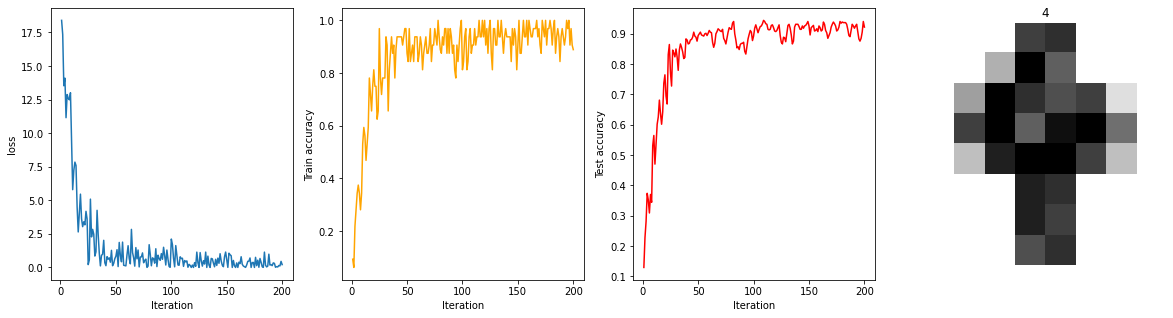

In [33]:
train_dataloader = dataloader(X_train, y_train, norm=False)
net = Net(Linear(64, 128, initialization=0.1), ReLU(), Linear(128, 10), Softmax())
opt = SGD(net.parameters, 0.0001, 0.8)
iter_count = train(train_dataloader, X_test, y_test, net, 
          opt, num_epochs=5, verbose_num_iters=10)

In [34]:
def result(net, iter_count):
    train_acc = accuracy(predict(net, X_train), y_train)
    test_acc = accuracy(predict(net, X_test), y_test)
    print(f'Train accuracy: {train_acc:.3f}\nTest accuracy: {test_acc:.3f} \n95% accuracy iteration: {iter_count}')

In [35]:
result(net, iter_count)

Train accuracy: 0.961
Test accuracy: 0.922 
95% accuracy iteration: 197


## Эксперименты с числом слоев (1 балл)

Ясно, что из-за случайного начального приближения с каждым запуском обучения мы будем получать различное качество. Попробуем обучить нашу нейросеть с разным числом слоев несколько раз.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети с $i+1$ полносвязными слоями при $j$-м запуске (все запуски идентичны).

In [36]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [37]:
def call_train(net, show=False):
    opt = SGD(net.parameters, 0.0001, 0.8)
    loss = train(train_dataloader, X_test, y_test, net, 
            opt, num_epochs=5, verbose_num_iters=10, show=show)
    a_train = accuracy(predict(net, X_train), y_train)
    a_test = accuracy(predict(net, X_test), y_test)
    return a_train, a_test

In [38]:
train_dataloader = dataloader(X_train, y_train, norm=False)

for i in range(5):
    for j in range(5):
        net = Net(i + 1, 0.1)
        accs_train[i][j], accs_test[i][j] = call_train(net)

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

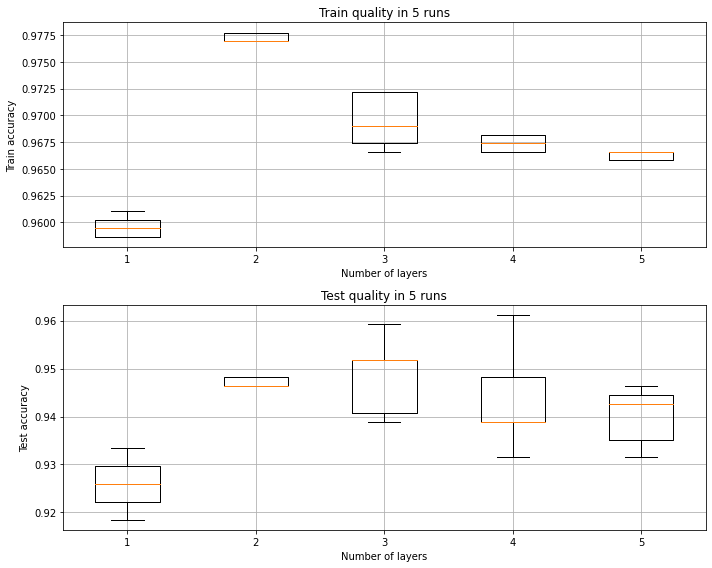

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, showfliers=False)
axes[1].boxplot(accs_test.T, showfliers=False)

axes[0].set_xlabel("Number of layers")
axes[1].set_xlabel("Number of layers")

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_title("Train quality in 5 runs")
axes[1].set_title("Test quality in 5 runs")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как изменяются качество на обучении и контроле и устойчивость процесса обучения при увеличении числа слоев?

__Ответы:__

Сначала качество и на тесте и на обучении, понятное дело, растет. Однако в какой-то момент число обучаемых параметров превысит размерность входных данных и сеть переобучится, так что на тесте качество снизится. Это можно наблюдать с 4 слоя.


## Эксперименты c различными инициализациями весов (1 балл)

Как уже было сказано, начальная инициализация весов нейронной сети может сильно влиять на процесс ее обучения и, как следствие, на ее качество.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными инициализациями слоев.

Для этого необходимо реализовать функцию, инициализирующую веса линейных слоёв нашей нейронной сети. Добавьте в функционал данного метода возможность инициализировать его веса с помощью инициализации Kaiming (используется, если в нейронной сети в качестве функций активации используется ReLU) и инициализации Xavier (используется, если в нейронной сети в качестве функций активации используется Tanh или Sigmoid):

Теперь попробуйте для каждой из 3 инициализаций обучить нейронную сеть несколько раз. Попробуйте проделать данную операцию при зафиксированном числе слоев равным 3, 4 и 5.

### 3 слоя

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с инициализацией Kaiming при $i = 3$, с инициализацией Xavier при $i = 4$ и с инициализацией из нормального распределения с фиксированными параметрами при $0 \leqslant i \leqslant 2$ (попробуйте здесь 3 разных параметра для стандартного отклонения для нормального распределения, например: `1e-3`, `1e-2`, `1e-1`). Заметьте, что при большом числе слоев слишком низкое стандартное отклонение может не давать нейронной сети нормально обучиться.

In [40]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [41]:
init_vars = [1e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [42]:
for i, init in enumerate(init_vars):
    for j in range(5):
        net = Net(3, init)
        accs_train[i][j], accs_test[i][j] = call_train(net)

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

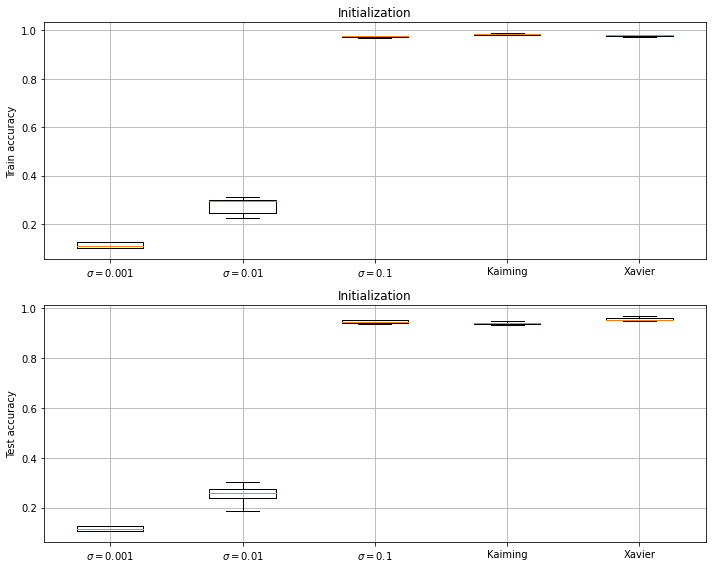

In [43]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, labels=init_vars_for_plot, showfliers=False)
axes[1].boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_title("Initialization")
axes[1].set_title("Initialization")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

### 4 слоя

Выполните тут тот же код, что и в предыдущем пункте, но только уже с 4 слоями в сети.

In [44]:
init_vars = [5e-3, 1e-2, 1e-1, 'Kaiming', 'Xavier']

In [45]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [46]:
for i, init in enumerate(init_vars):
    for j in range(5):
        net = Net(4, init)
        accs_train[i][j], accs_test[i][j] = call_train(net)

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

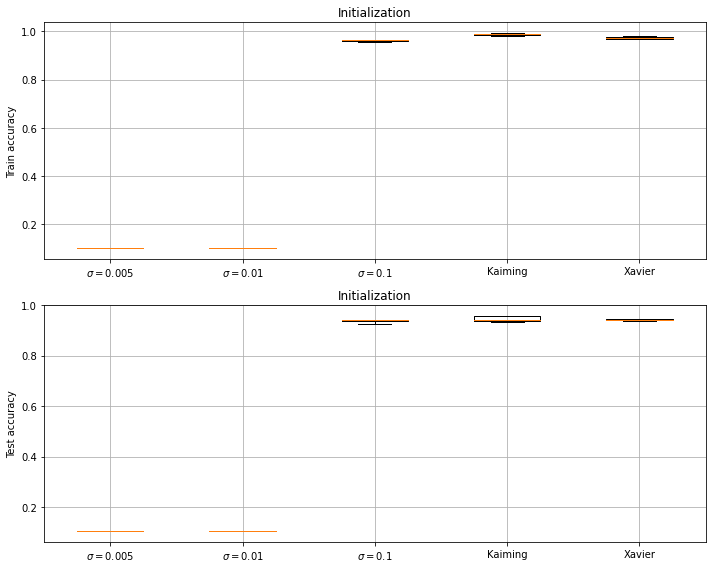

In [47]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, labels=init_vars_for_plot, showfliers=False)
axes[1].boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_title("Initialization")
axes[1].set_title("Initialization")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

### 5 слоев

Выполните тут тот же код, что и в предыдущем пункте, но только уже с 5 слоями в сети.

In [48]:
init_vars = [1e-2, 1e-1, 1e0, 'Kaiming', 'Xavier']

In [49]:
accs_train = np.zeros((5, 5))
accs_test = np.zeros((5, 5))

In [50]:
for i, init in enumerate(init_vars):
    for j in range(5):
        net = Net(5, init)
        accs_train[i][j], accs_test[i][j] = call_train(net)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

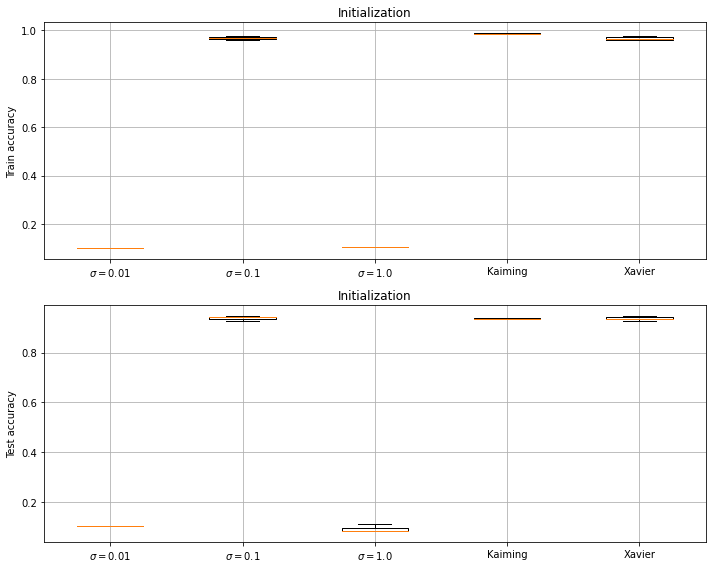

In [51]:
init_vars_for_plot = [(x if isinstance(x, str) else fr"$\sigma = {x}$") for x in init_vars]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, labels=init_vars_for_plot, showfliers=False)
axes[1].boxplot(accs_test.T, labels=init_vars_for_plot, showfliers=False)

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_title("Initialization")
axes[1].set_title("Initialization")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как отличаются качество на обучении и контроле и устойчивость процесса обучения при различных инициализациях?
* Какие инициализации помогают обучать более глубокие сети?

__Ответы:__

Почему почти одинково хорошее качество в трех испытаниях (2, 4, 5)? Потому что 0.1 - это практически параметр Ксавье (корень из 1 / 100 = 0.1), а Ксавье и Каиминг показывают себя отлично. До этого веса слишком близки к нулю и сеть умирает без обучения, 1 - слишком много, сеть при неудачных весах взрывается и улетает за пределы видимой Вселенной. 
Очевидно, глубокие сети нужно обучать со специальными параметрами.

## Эксперименты c различными функциями активации (1 балл)

Проверим теперь, с какой функцией активации нейронная сеть будет обучаться лучше.

В этом пункте вам предлагается попробовать обучить несколько нейронных сетей с различными функциями активации.

Для этого нам нужно реализовать еще 2 слоя: для функций активации `Tanh` и `Sigmoid`.

Теперь попробуйте для каждой из 3 функций активации обучить нейронную сеть несколько раз. Число слоев зафиксируйте равным 3. В случае `Tanh` и `Sigmoid` используйте инициализацию `Xavier`, а в случае `ReLU` используйте инициализацию `Kaiming`.

Заполните матрицы `accs_train` и `accs_test`. В позиции `[i, j]` должна стоять величина доли правильных ответов сети при $j$-м запуске (все запуски идентичны) с функцией активации $ReLU$ при $i = 0$, с функцией активации $Tanh$ при $i = 1$ и с функцией активации $Sigmoid$ при $i = 2$.

In [52]:
init_for_act_funcs = ['Kaiming', 'Xavier', 'Xavier']
act_func_vars = ['ReLU', 'Tanh', 'Sigmoid']

In [53]:
accs_train = np.zeros((3, 5))
accs_test = np.zeros((3, 5))

In [55]:
for i in range(3):
    for j in range(5):
        net = Net(3, init_for_act_funcs[i], act_func_vars[i])
        accs_train[i][j], accs_test[i][j] = call_train(net)

Построим боксплоты полученного качества (горизонтальная линия в каждом столбце — среднее, прямоугольник показывает разброс).

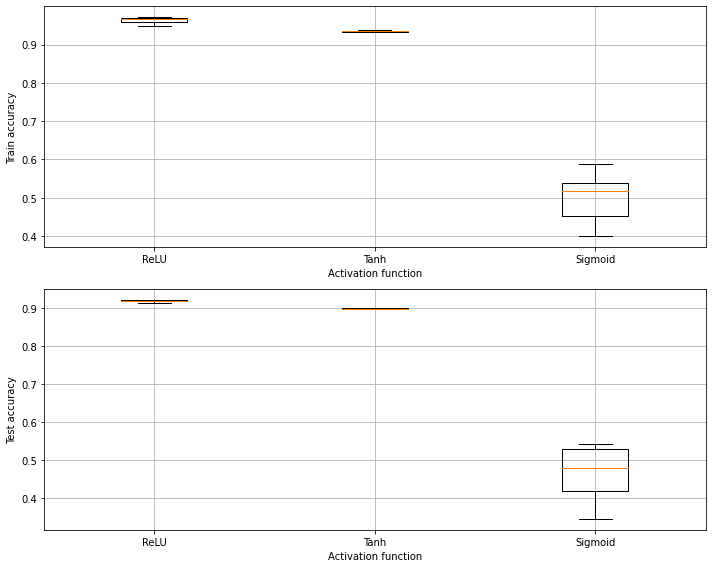

In [56]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].boxplot(accs_train.T, labels=act_func_vars, showfliers=False)
axes[1].boxplot(accs_test.T, labels=act_func_vars, showfliers=False)

axes[0].set_ylabel("Train accuracy")
axes[1].set_ylabel("Test accuracy")

axes[0].set_xlabel("Activation function")
axes[1].set_xlabel("Activation function")

axes[0].grid(True)
axes[1].grid(True)

fig.tight_layout()
plt.show()

Дайте развёрнутый ответ на вопросы (в этой же ячейке):
* Как отличаются качество на обучении и контроле и устойчивость процесса обучения при различных функциях активации?

__Ответы:__

ReLU c инициализацией Kaiming показывает себя превосходно. Тангенс так же дал отличные результаты с инициализацией Xavier. А вот сигмоида оказалась весьма нестабильной. Градиент этой функции, очевидно, умер из-за почти нулевых изменений (ибо сигмоида очень зависит от интервалов входящих данных, например вблизи -10 или 10, там сигмоида - практически прямая линия, градиент которой 0. Это исправляется нормализацией данных, эксперимент на эту тему будет в бонусной части.

\* Несколько фрагментов кода в задании написаны на основе материалов [курса по глубинному обучению на ФКН НИУ ВШЭ](https://www.hse.ru/ba/ami/courses/205504078.html)

## Бонусная часть

## Реализация метода оптимизации (1 балл)

Реализуйте сами метод оптимизации (аналог функции `minimize`) для рассмотренной выше архитектуры. В качестве метода оптимизации используйте SGD + momentum. Продемонстрируйте правильную работу метода оптимизации, сравните его работу с LBFGS-B. Сделайте выводы.

In [57]:
class SGD():
    """
    Оптимизатор SGD + momentum
    Необучаемые параметры:
    - lr - learning rate - скорость обучения
    - momentum - коэф-т превалирования движения по скорости v
    - v - накопление импульса
    """
    def __init__(self, parameters, lr=1.0, momentum=0):
        self.parameters = parameters
        self.lr = lr
        self.momentum = momentum
        self.v = []
        self.set_v()

    def set_v(self):
        """
        Устанавливает параметр нужного формата (по нулевым
        массивам нужного размера на каждый параметр)
        """
        self.v = [np.zeros_like(param.grad) for param in self.parameters]

    def zero_grad(self):
        """
        Обнуление градиентов всех параметров.
        """
        for param in self.parameters:
            param.grad = np.zeros_like(param.value)

    def step(self):
        """
        Корректировка значений параметров в соответствии с градиентом
        """
        for i, param in enumerate(self.parameters):
            self.v[i] = self.v[i] * self.momentum - self.lr * param.grad
            param.value += self.v[i]

Дополнителььно был реализован оптимизатор __Adam__.

In [58]:
class Adam():
    """
    Оптимизатор Adam. Используются сгруппированные средние как градиентов, 
    так и вторых моментов градиентов.
    Необучаемые параметры:
    - lr - learning rate - скорость обучения
    - beta_1, beta_2 - коэ-ты забывания для градиентов и вторых моментов градиентов
    - eps - поправка для предотвращения деления на 0
    - v - накопление импульса
    - m - накопление средней нецентрированной дисперсии (второй момент)
    - step_count - число шагов оптимизатора
    """
    def __init__(self, parameters, lr=1.0, beta_1=0.9, beta_2=0.999, eps=1e-8):
        self.parameters = parameters
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.eps = eps
        self.m = []
        self.v = []
        self.set_v()
        self.step_count = 0

    def set_v(self):
        """
        Устанавливает параметр нужного формата (по нулевым
        массивам нужного размера на каждый параметр)
        """
        for param in self.parameters:
            self.v.append(np.zeros_like(param.grad))
            self.m.append(np.zeros_like(param.grad))

    def zero_grad(self):
        """
        Обнуление градиентов всех параметров.
        """
        for param in self.parameters:
            param.grad = np.zeros_like(param.value)

    def step(self):
        """
        Корректировка значений параметров в соответствии с градиентом
        """
        self.step_count += 1
        for i, param in enumerate(self.parameters):
            self.v[i] = self.v[i] * self.beta_1 + (1. - self.beta_1) * param.grad
            self.m[i] = self.m[i] * self.beta_2 + (1. - self.beta_2) * (param.grad * param.grad)
            v_temp = self.v[i] / (1.0 - (self.beta_1 ** self.step_count))
            m_temp = self.m[i] / (1.0 - (self.beta_2 ** self.step_count))

            param.value += (-self.lr) * v_temp / (np.sqrt(m_temp) + self.eps)

Пример работы:

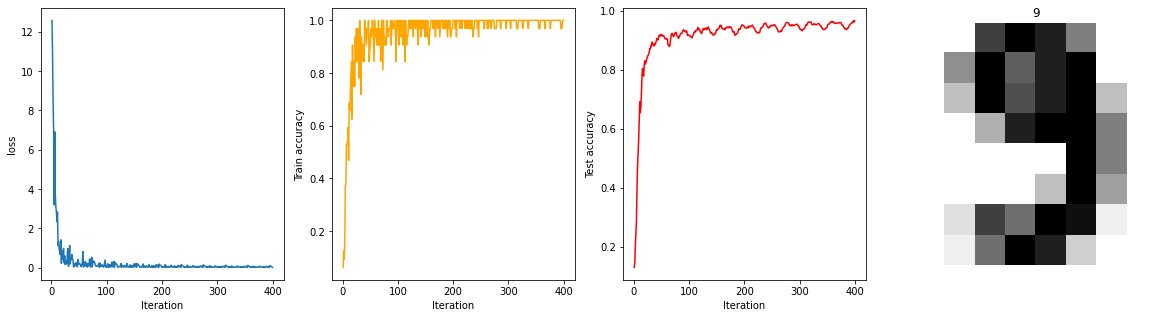

In [59]:
net = Net(Linear(64, 128, initialization='Kaiming'), ReLU(), 
          Linear(128, 10, initialization='Xavier'), Softmax())
opt = SGD(net.parameters, 0.0001, 0.8)
iter_count = train(train_dataloader, X_test, y_test, net, 
          opt, num_epochs=10, verbose_num_iters=10)

In [60]:
result(net, iter_count)

Train accuracy: 0.994
Test accuracy: 0.963 
95% accuracy iteration: 399


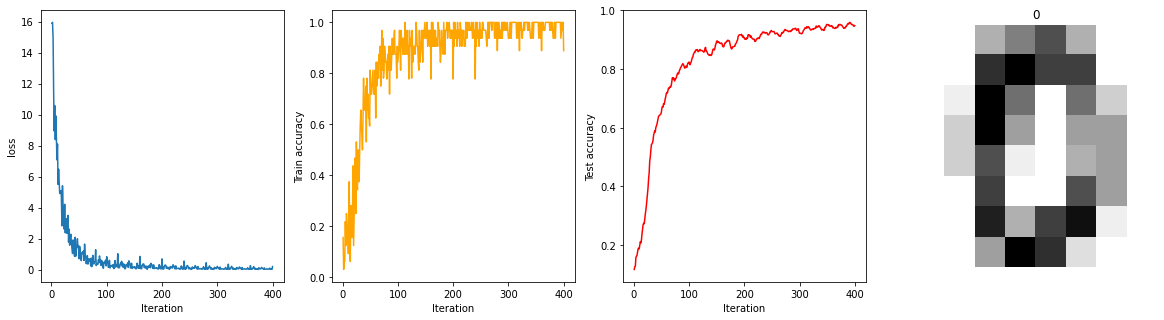

In [61]:
net = Net(Linear(64, 128, initialization='Kaiming'), ReLU(), 
          Linear(128, 10, initialization='Xavier'), Softmax())
opt = Adam(net.parameters, lr=0.001)
iter_count = train(train_dataloader, X_test, y_test, net, 
          opt, num_epochs=10, verbose_num_iters=10)

In [62]:
result(net, iter_count)

Train accuracy: 0.986
Test accuracy: 0.948 
95% accuracy iteration: 398


Как видно, оптимизаторы справляются со своей работой. А Adam всё-таки чуть быстрее достиг качества в 95%

## Dropout (1 балл) 

Реализуйте слой Dropout. Сравните обучение сети из большого числа слоёв при использовании Dropout и без его использования (предварительно подберите адекватный параметр $p$). Сделайте выводы.

In [61]:
class Dropout(Module):
    """
    Слой регуляризации и предотвращения коадаптации нейронов на основе базового.
    Во время обучения случайным образом обнуляет некоторые элементы входного 
    тензора с вероятностью, pиспользуя выборки из распределения Бернулли.
    p - вероятность обнуления каждого нейрона.
    Необучаемые параметры:
    - retain_rate - коэф-т масштабирования выхода
    - mask - маска, накладывающаяся на выход с предыдущего слоя
    """
    def __init__(self, p=0.5):
        super().__init__()
        self.retain_rate = 1.0 - p
        self.mask = None

    def forward(self, input):
        """
        Прямой ход через слой
        """
        self.mask = np.random.binomial(1, self.retain_rate, input.shape).astype(float)
        self.mask /= self.retain_rate
        return self.mask * input

    def backward(self, out):
        """
        Обратное распространение ошибки
        """
        return out * self.mask / self.retain_rate

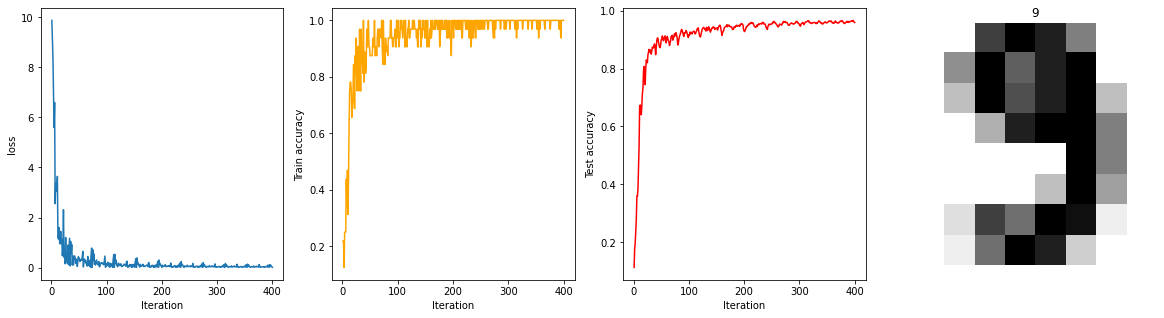

In [65]:
net = Net(Linear(64, 128, initialization='Kaiming'), ReLU(),
          Linear(128, 10, initialization='Xavier'), Softmax())
opt = SGD(net.parameters, 0.0001, 0.8)
iter_count = train(train_dataloader, X_test, y_test, net, 
          opt, num_epochs=10, verbose_num_iters=10)

In [66]:
result(net, iter_count)

Train accuracy: 0.994
Test accuracy: 0.959 
95% accuracy iteration: 399


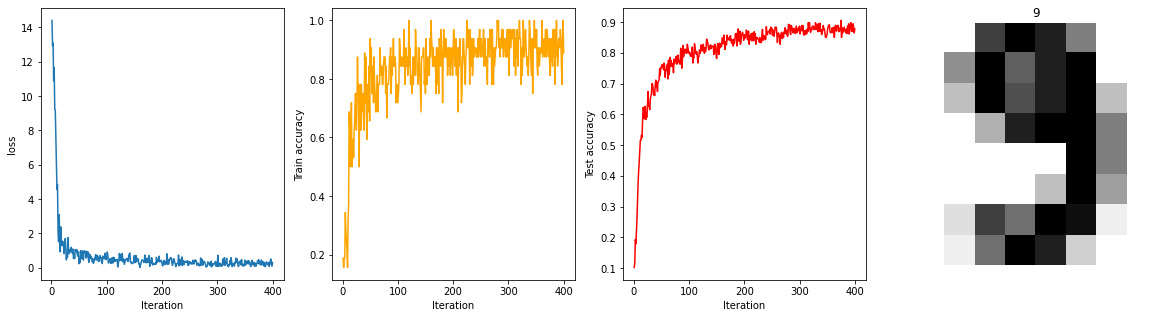

In [67]:
net = Net(Linear(64, 128, initialization='Kaiming'), Dropout(), ReLU(),
          Linear(128, 10, initialization='Xavier'), Softmax())
opt = SGD(net.parameters, 0.0001, 0.8)
iter_count = train(train_dataloader, X_test, y_test, net, 
          opt, num_epochs=10, verbose_num_iters=10)

In [68]:
result(net, iter_count)

Train accuracy: 0.928
Test accuracy: 0.906 
95% accuracy iteration: 398


## BatchNormalization (1 балл)

Реализуйте слой `BatchNormalization`. Сравните обучение сети из большого числа слоёв при использовании `BatchNormalization` и без его использования. Сделайте выводы.

In [69]:
class BatchNorm(Module):
    """
    Слой батч-нормализации на основе базового Module.
    К обучаемым параметрам относятся:
    - gamma - масштабирование выходных данных
    - beta - сдвиг выходных данных
    К необучаемым параметрам относятся:
    -eps - поправка от деления на 0
    - n_input - число нейронов на слое нормализации 
    """
    def __init__(self, n_input, eps=1e-05, momentum=0.1):
        super().__init__()
        self.n_input = n_input
        self.gamma = Parameter(np.ones((1, self.n_input)))
        self.beta = Parameter(np.zeros((1, self.n_input)))
        self.eps = eps
        self.reset_parameter()

    def forward(self, input):
        """
        Прямое распространение данных. 
        Выход из этого слоя - нормализованные входные данные этого слоя.
        - E - матожидание по каждому признаку (по всем вышедшим 
        из одного нейрона предыдущего слоя значений) (среднее)
        - V - дисперсия по каждому признаку
        """
        self.input_1 = Parameter(input)
        self.E = Parameter(np.mean(input, axis=0, keepdims=True))
        self.V = Parameter(1 / np.sqrt(np.var(input, axis=0, keepdims=True) + self.eps))
        self.input_2 = Parameter((input - self.E.value) * self.V.value)
        return self.input_2.value * self.gamma.value + self.beta.value 

    def backward(self, out):
        """
        Обратное распространение ошибки в 6 шагов с 
        вычислением градиентов весов gamma и сдвигов beta.
        """
        N = out.shape[0]
        # step 1
        self.input_2.grad = out * self.gamma.value

        # step 2
        temp1 = self.input_2.grad * self.input_2.value * self.V.value**2
        self.V.grad = -0.5 * np.sum(temp1, axis=0, keepdims=True)
        
        # step 3
        temp1 = np.sum(self.input_2.grad * self.V.value, axis=0, keepdims=True)
        temp2 = np.mean(self.input_1.value - self.E.value, axis=0, keepdims=True)
        temp3 = self.V.grad * temp2
        self.E.grad = -(temp1 + 2 * temp3)

        # step 4
        temp1 = self.input_2.grad * self.V.value
        temp2 = self.V.grad * (self.input_1.value - self.E.value) / N
        temp3 = self.E.grad / N
        self.input_1.grad = temp1 + 2 * temp2 + temp3
                            
        # step 5
        self.gamma.grad = np.sum(out * self.input_2.value, axis=0, keepdims=True)

        # step 6
        self.beta.grad = np.sum(out, axis=0, keepdims=True)

        return self.input_1.grad

    def reset_parameter(self):
        """
        Регистрация обучаемых параметров.
        """
        self.register_parameter('gamma', self.gamma)
        self.register_parameter('beta', self.beta)

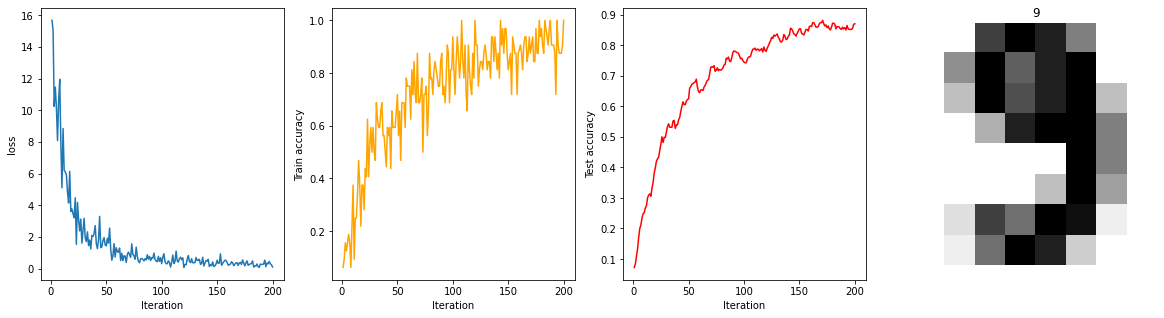

In [70]:
net = Net(Linear(64, 128, initialization=1.0), Sigmoid(),
          Linear(128, 10, initialization=1.0), Softmax())
opt = SGD(net.parameters, 0.001, 0.8)
iter_count = train(train_dataloader, X_test, y_test, net, 
          opt, num_epochs=5, verbose_num_iters=10)

In [71]:
result(net, iter_count)

Train accuracy: 0.932
Test accuracy: 0.870 
95% accuracy iteration: 199


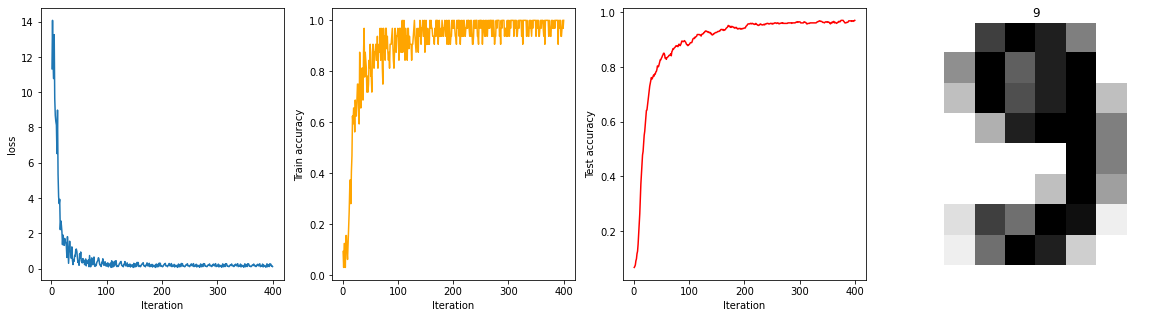

In [72]:
net = Net(Linear(64, 128, initialization=1.0), BatchNorm(128), Sigmoid(),
          Linear(128, 10, initialization=1.0), Softmax())
opt = SGD(net.parameters, 0.001, 0.8)
iter_count = train(train_dataloader, X_test, y_test, net, 
          opt, num_epochs=10, verbose_num_iters=10)

In [73]:
result(net, iter_count)

Train accuracy: 0.986
Test accuracy: 0.970 
95% accuracy iteration: 399


Сеть с нормализацией, даже если учесть, что без нее сеть в принципе обучилась, все равно выигрывает по качеству и сходится быстрее. 